# Homework 1
In this homework, we will have you train some convolutional neural networks! We will start with a small dataset (CIFAR), and then work our way up to TinyImageNet! This homework originally written by Daniel Gordon with very minor modifications.

# Initial Setup

This will authenticate Colab to connect to your google drive account. This way you have space to store the datasets and won't have to redownload them every time. You'll also have stable storage to save your best performing networks.

In [1]:
from google.colab import drive
drive.mount('/gdrive/')
!ls /gdrive

Mounted at /gdrive/
'My Drive'  'Shared drives'


Run this code to navigate to the BASE_PATH directory and upload the homework2.tar file inside the BASE_PATH, then extract it.

Have a look at [pt_util](https://gist.github.com/pjreddie/e531394d779af2da9201096af0dba78a). We moved some of the useful functions out of the python notebook to make it less cluttered, and added a few more useful functions.

I made the BASE_PATH and DATA_PATH variables so you don't have to copy the same strings all over the place if you want to move the locations of the files around.

In [2]:
import os

BASE_PATH = '/gdrive/My Drive/colab_files/hw1/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = BASE_PATH + 'tiny_imagenet/'

!pwd
!ls
os.chdir(BASE_PATH)
if not os.path.exists(DATA_PATH + 'train.h5'):
    !wget https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework2.tar
    !tar -xvf homework2.tar
    !rm homework2.tar
!pwd
!ls
os.chdir('/content')

/content
sample_data
/gdrive/My Drive/colab_files/hw1
cifar  pt_util.py  __pycache__	tiny_imagenet


# CIFAR

## Part 1: Getting the Dataset
Normally, we'd want to download our dataset first. Since PyTorch hosts the CIFAR dataset, we can load it using their helper function later.

But, we'll change DATA_PATH to an empty directory to download the dataset to.

In [3]:
DATA_PATH = BASE_PATH + 'cifar/'

## Part 2: Defining the Network
Just like with MNIST last homework we need to define our network architecture. This time we will be using convolutional layers and maxpooling to extract features from our images before we feed those features into our final classifier.

Check out the documentation for [nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html):

    nn.Conv2d(in_channels, out_channels, kernel_size, stride = 1, padding = 0,...)

So the first parameter is the number of channels in the input. Second is the number of filters we'll use (AKA number of channels in the output). Third is kernel size. Next is stride and padding which are optional and have default values.

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import os
import torch.nn.functional as F
import torch.optim as optim
import h5py
import sys
sys.path.append(BASE_PATH)
import pt_util
import matplotlib.pyplot as plt

In [ ]:
class CifarNet(nn.Module):
    def __init__(self):
        super(CifarNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, stride=2, padding=1)
        self.max1 = nn.MaxPool2d(2, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
        self.max2 = nn.MaxPool2d(2, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.max3 = nn.MaxPool2d(2, stride=2, padding=1)
        self.fc1 = nn.Linear(256, 10)
        self.accuracy = None

#Original: 
        # self.conv1 = nn.Conv2d(3, 16, 3, stride=2, padding=1)
        # self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
        # self.conv3 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        # self.fc1 = nn.Linear(1024, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.max1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.max2(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.max3(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction, label.squeeze(), reduction=reduction)
        return loss_val

    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)
        
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if self.accuracy == None or accuracy > self.accuracy:
            self.accuracy = accuracy
            self.save_model(file_path, num_to_keep)

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)


This time we are giving you the train and test functions, but feel free to modify them if you want. 

You may need to return some additional information for the logging portion of this assignment.


In [ ]:
import time
def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    losses = []
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('{} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                time.ctime(time.time()),
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)

def test(model, device, test_loader, log_interval=None):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output = model(data)
            test_loss_on = model.loss(output, label, reduction='sum').item()
            test_loss += test_loss_on
            pred = output.max(1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            if log_interval is not None and batch_idx % log_interval == 0:
                print('{} Test: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    time.ctime(time.time()),
                    batch_idx * len(data), len(test_loader.dataset),
                    100. * batch_idx / len(test_loader), test_loss_on))

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), test_accuracy))
    return test_loss, test_accuracy

## Part 3 and 4: Loading Data and Dataset Augmentation

In the MNIST assignment, we didn't do any data augmentation because MNIST is kind of easy.

In this assignment, you may find that data augmentation helps you a lot (or possibly hurts your performance).

You can find a bunch preimplemented here https://pytorch.org/docs/stable/torchvision/transforms.html and you can also do your own as seen in the tutorial from part 3.

Play around with various data augmentations we will suggest some.

- ToPILImage - This one is useful for a lot of the built in transforms which expect PIL images. 
- RandomHorizontalFlip
- RandomResizedCrop
- ColorJitter
- RandomRotation
- Normalize
- Adding various types of noise
- ToTensor - PyTorch expects the output from the dataset to be a tensor in CxHxW format.


Note: You should be careful about which of these you apply to the test data. You usually don't want to apply noise to the test data, but you do want to normalize it in the same way for example.

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    #transforms.RandomAffine(15, (.1, .1), (.95, 1.05), .1),
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

data_train = datasets.CIFAR10(root=DATA_PATH, train=True, download=True, transform=transform_train)
data_test = datasets.CIFAR10(root=DATA_PATH, train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


## Part 5: Training the network
Generally, it is useful to see how your training is going. Often people print their loss to make sure it goes down and their accuracy to make sure it goes up. But pictures are better than words. So for this part, you should record and plot the training loss, test loss, and test accuracy (and whatever else you want). 

We have created a very simple logging interface which essentially just saves and restores files via pickle in pt_util. Saving and restoring log data is important if you end your run early and want to continue where you left off rather than starting over.

We have also provided a plot function which can plot a single line graph. You can use it and plot each value independently, or change it to plot them all in one graph. 

Try different network architectures and experiment with hyperparameters. You'll answer the questions at the bottom of the file based on these experiments.


__Important note: Do not forget to title your graphs and label your axes. Plots are meaningless without a way to read them.__

Second Note: It will be helpful for you when deciding what network structure, data augmentation, and such work to title the graphs accordingly so you remember.

Third Note: The default setup right now saves and restores the network weights from a single folder. When you modify network architectures, you may want to increment your experiment version number so you start over with your training and log files.

Using device cuda
num cpus: 2
Restoring:
conv1.weight -> 	torch.Size([16, 3, 3, 3]) = 0MB
conv1.bias -> 	torch.Size([16]) = 0MB
conv2.weight -> 	torch.Size([32, 16, 3, 3]) = 0MB
conv2.bias -> 	torch.Size([32]) = 0MB
conv3.weight -> 	torch.Size([64, 32, 3, 3]) = 0MB
conv3.bias -> 	torch.Size([64]) = 0MB
fc1.weight -> 	torch.Size([10, 256]) = 0MB
fc1.bias -> 	torch.Size([10]) = 0MB

Restored all variables
No new variables
Restored /gdrive/My Drive/colab_files/hw1/cifar/logs/0.4/030.pt

Test set: Average loss: 1.0682, Accuracy: 6294/10000 (63%)

Fri Oct 30 19:14:04 2020 Train Epoch: 30 [0/50000 (0%)]	Loss: 1.124200
Fri Oct 30 19:14:11 2020 Train Epoch: 30 [25600/50000 (51%)]	Loss: 0.976104

Test set: Average loss: 1.0619, Accuracy: 6235/10000 (62%)

Saved /gdrive/My Drive/colab_files/hw1/cifar/logs/0.4/030.pt

Saved /gdrive/My Drive/colab_files/hw1/cifar/logs/0.4/030.pt



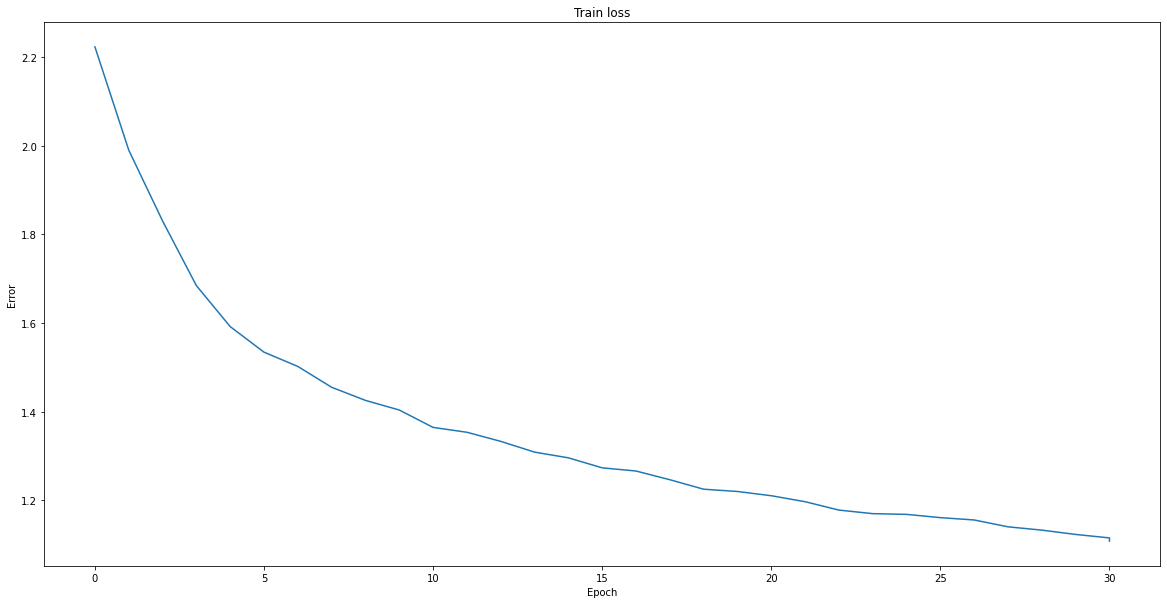

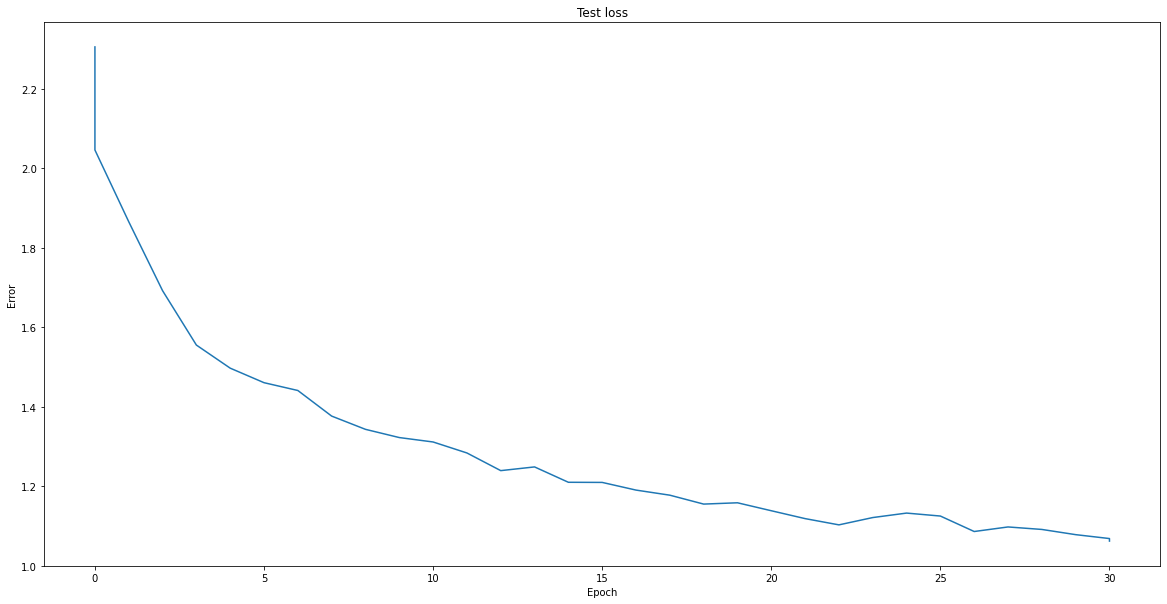

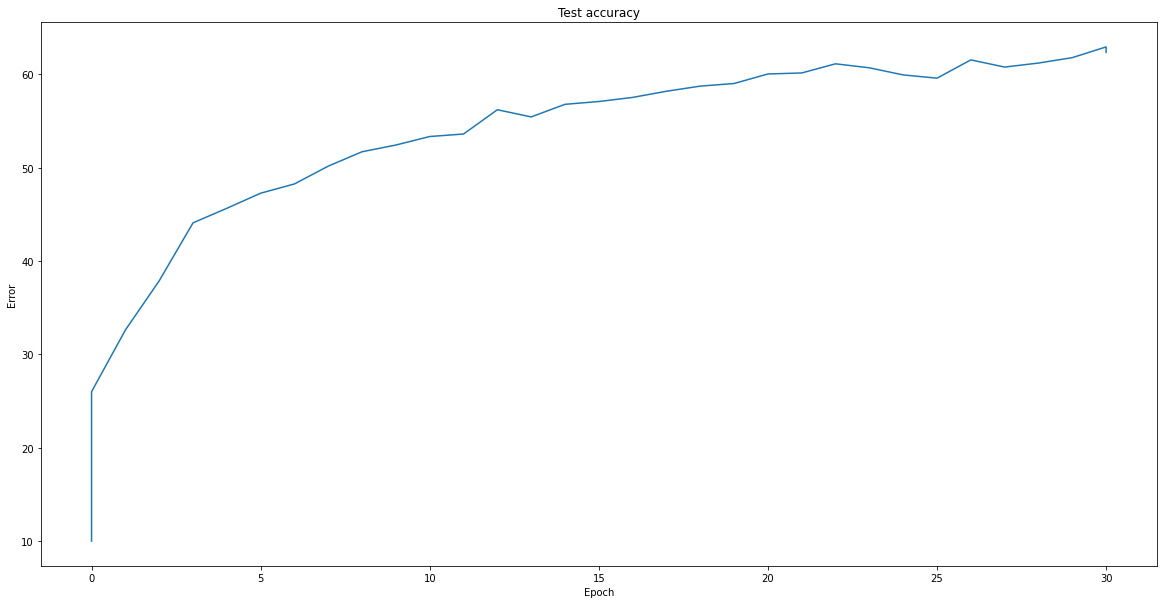

In [ ]:
# Play around with these constants, you may find a better setting.
BATCH_SIZE = 256
TEST_BATCH_SIZE = 10
EPOCHS = 30
LEARNING_RATE = 0.01
MOMENTUM = 0.9
USE_CUDA = True
SEED = 0
PRINT_INTERVAL = 100
WEIGHT_DECAY = 0.0005

EXPERIMENT_VERSION = "0.4" # increment this to start a new experiment
LOG_PATH = DATA_PATH + 'logs/' + EXPERIMENT_VERSION + '/'

# Now the actual training code
use_cuda = USE_CUDA and torch.cuda.is_available()

#torch.manual_seed(SEED)

device = torch.device("cuda" if use_cuda else "cpu")
print('Using device', device)
import multiprocessing
print('num cpus:', multiprocessing.cpu_count())

kwargs = {'num_workers': multiprocessing.cpu_count(),
          'pin_memory': True} if use_cuda else {}

class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                           shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                          shuffle=False, **kwargs)

model = CifarNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
start_epoch = model.load_last_model(LOG_PATH)

train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH + 'log.pkl', ([], [], []))
test_loss, test_accuracy = test(model, device, test_loader)

test_losses.append((start_epoch, test_loss))
test_accuracies.append((start_epoch, test_accuracy))

try:
    for epoch in range(start_epoch, EPOCHS + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch, PRINT_INTERVAL)
        test_loss, test_accuracy = test(model, device, test_loader)
        train_losses.append((epoch, train_loss))
        test_losses.append((epoch, test_loss))
        test_accuracies.append((epoch, test_accuracy))
        pt_util.write_log(LOG_PATH + 'log.pkl', (train_losses, test_losses, test_accuracies))
        model.save_best_model(test_accuracy, LOG_PATH + '%03d.pt' % epoch)


except KeyboardInterrupt as ke:
    print('Interrupted')
except:
    import traceback
    traceback.print_exc()
finally:
    model.save_model(LOG_PATH + '%03d.pt' % epoch, 0)
    ep, val = zip(*train_losses)
    pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
    ep, val = zip(*test_losses)
    pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
    ep, val = zip(*test_accuracies)
    pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')


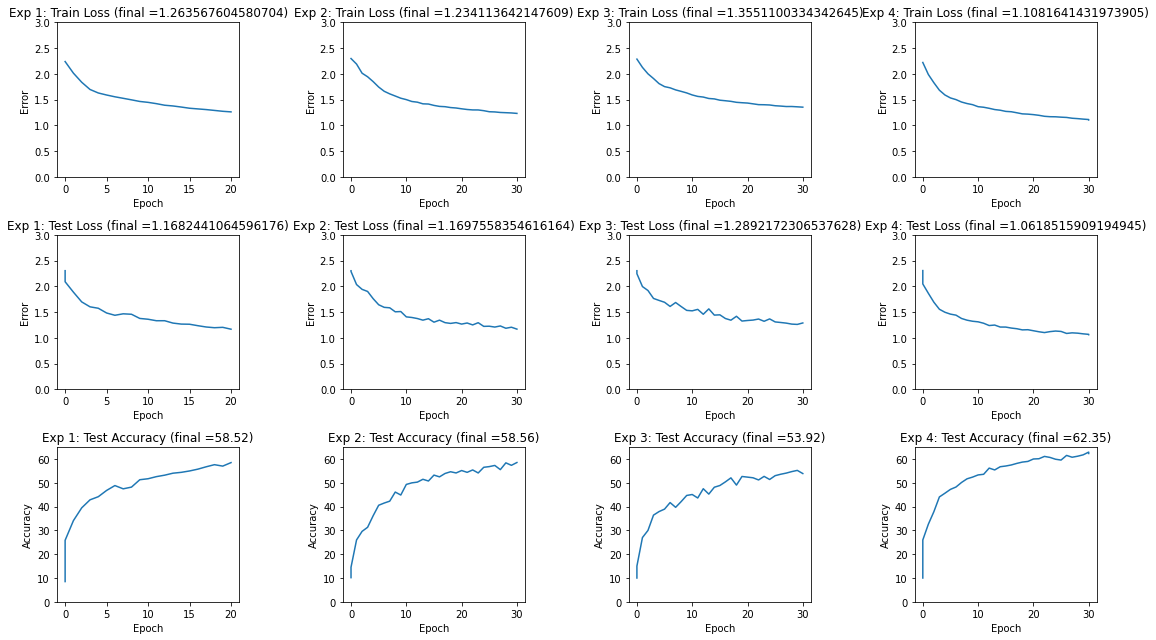

In [ ]:
# 0.1 is default
# 0.2 is increasing epochs to 30 while adding maxpooling (kept for further experiments)
# 0.3 is using transforms.RandomAffine(15, (.1, .1), (.95, 1.05), .1) on training set
# 0.4 is normalizing augmentation on both test and train sets

plt.rcParams["figure.figsize"] = [16, 9]
num_exp = 4; 
for i in range(1, num_exp+1): 
  for j in range (3): 
    LOG_PATH_GRAPH = DATA_PATH + 'logs/' + "0." + str(i) + '/' + 'log.pkl'
    file_graph = pt_util.read_log(LOG_PATH_GRAPH) 

    plt.subplot(3, num_exp, num_exp * j + i)
    plt.ylim(0, 65 if j == 2 else 3)
    plt.plot([x for x,y in file_graph[j]], [y for x,y in file_graph[j]])

    title_label = ['Train Loss', 'Test Loss', 'Test Accuracy']
    y_label = ['Error', 'Error', 'Accuracy']
    plt.title('Exp ' + str(i) + ': ' + str(title_label[j]) + ' (final =' + str(file_graph[j][-1][1]) + ')')
    plt.xlabel('Epoch')
    plt.ylabel(str(y_label[j]))

plt.tight_layout()
plt.show()

##CIFAR Questions

1. What design that you tried worked the best? This includes things like network design, learning rate, batch size, number of epochs, and other optimization parameters, data augmentation etc. What was the final train loss? Test loss? Test Accuracy? Provide the plots for train loss, test loss, and test accuracy.

The default final test accuracy was 58.52. Our first experiment (exp 2) was to increase the epochs to 30 and introduce maxpooling (2x2, stride 2) after each convolutional layer. This slightly increased the final accuracy to 58.56, so we kept it for further experiments. The learning rate, momentum, and weight decay seemed fine from the values we experimented with in our previous homework. 

In our final experiment (exp 4), we normalized both the training and testing set. This resulted in a final accuracy of 62.35. 

2. What design worked the worst (but still performed better than random chance)? Provide all the same information as question 1.

In our next experiment (exp 3), we applied random affine transformations when augmenting the training set. This resulted in lowering our final test accuracy to 53.92. 

3. Why do you think the best one worked well and the worst one worked poorly.

We think exp 3 was worse because the affine transformations did not accurately produce the effects of differing imaging angles. We think exp 4 worked well because it reduced the effects of lighting conditons and other properties of the camera, so that individual images of certain classes are more standardized/ consistent. Additionally, centering the data allows the activation functions to better separate the features from the image.

---
# TinyImageNet

## Part 1: Upload the Dataset
Change the DATA_PATH to the path of the TinyImageNet dataset we downloaded earlier.

In [3]:
DATA_PATH = BASE_PATH + 'tiny_imagenet/'

## Part 2: Defining the Network
We're giving you no instructions on this part. Welcome to deep learning research! See if you can get above 40% accuracy. You probably want to use the Cross Entropy error again, but who knows, maybe you can find a better loss function. We will give you a few hints of things to try:

- Maxpooling
- Activation functions other than ReLU
- Batch Norm
- Dropout
- Residual connections

To define your network you'll have to figure out more about the Tiny ImageNet dataset. Specifically, what size are the images you'll be processing? How big is your label space? You can find this out by examining samples of your data.

In [4]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import os
import torch.nn.functional as F
import torch.optim as optim
import h5py
import sys
sys.path.append(BASE_PATH)
import pt_util
import matplotlib.pyplot as plt

In [5]:
class TinyImagenetNet(nn.Module):
    def __init__(self):
        super(TinyImagenetNet, self).__init__()
          # TODO define the layers
        # 200 classes, 500 training images, 50 validation, 50 test, 64x64 pixels
        self.conv1 = nn.Conv2d(3, 16, 3, stride=1, padding=1)
        self.batch1 = nn.BatchNorm2d(16)
        self.max1 = nn.MaxPool2d(2, stride=2, padding=1)
        # 16 x 32 x 32
        self.conv2 = nn.Conv2d(16, 32, 3, stride=1, padding=1)
        self.batch2 = nn.BatchNorm2d(32)
        self.max2 = nn.MaxPool2d(2, stride=2, padding=1)
        # 32 x 16 x 16
        self.conv3 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.batch3 = nn.BatchNorm2d(64)
        self.max3 = nn.MaxPool2d(2, stride=2, padding=1)
        # 64 x 8 x 8
        self.conv4 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.batch4 = nn.BatchNorm2d(128)
        self.max4 = nn.MaxPool2d(2, stride=2, padding=1)
        # 128 x 4 x 4
        self.conv5 = nn.Conv2d(128, 256, 3, stride=1, padding=1)
        self.batch5 = nn.BatchNorm2d(256)
        self.avg = nn.AvgPool2d(4)
        # 256 x 1 x 1
        self.conv6 = nn.Conv2d(256, 200, 1, stride=1, padding=0)
        # 200 x 1 x 1

        self.accuracy = None

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch1(x)
        x = F.leaky_relu(x, 0.1)
        x = self.max1(x)


        x = self.conv2(x)
        x = self.batch2(x)
        x = F.leaky_relu(x, 0.1)
        x = self.max2(x)

        x = self.conv3(x)
        x = self.batch3(x)
        x = F.leaky_relu(x, 0.1)
        x = self.max3(x)

        x = self.conv4(x)
        x = self.batch4(x)
        x = F.leaky_relu(x, 0.1)
        x = self.max4(x)

        x = self.conv5(x)
        x = self.batch5(x)
        x = F.leaky_relu(x, 0.1)
        x = self.avg(x)

        x = self.conv6(x)
        x = x.flatten(1)

        return x

    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction, label.squeeze(), reduction=reduction)
        return loss_val

    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)
        
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if self.accuracy == None or accuracy > self.accuracy:
            self.accuracy = accuracy
            self.save_model(file_path, num_to_keep)

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

This time we are giving you the train and test functions, but feel free to modify them if you want. 

You may need to return some additional information for the logging portion of this assignment.


In [6]:
import time
def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    losses = []
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('{} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                time.ctime(time.time()),
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)

def test(model, device, test_loader, return_images=False, log_interval=None):
    model.eval()
    test_loss = 0
    correct = 0

    correct_images = []
    correct_values = []

    error_images = []
    predicted_values = []
    gt_values = []
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output = model(data)
            test_loss_on = model.loss(output, label, reduction='sum').item()
            test_loss += test_loss_on
            pred = output.max(1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            if return_images:
                if num_correct > 0:
                    correct_images.append(data[correct_mask, ...].data.cpu().numpy())
                    correct_value_data = label[correct_mask].data.cpu().numpy()[:, 0]
                    correct_values.append(correct_value_data)
                if num_correct < len(label):
                    error_data = data[~correct_mask, ...].data.cpu().numpy()
                    error_images.append(error_data)
                    predicted_value_data = pred[~correct_mask].data.cpu().numpy()
                    predicted_values.append(predicted_value_data)
                    gt_value_data = label[~correct_mask].data.cpu().numpy()[:, 0]
                    gt_values.append(gt_value_data)
            if log_interval is not None and batch_idx % log_interval == 0:
                print('{} Test: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    time.ctime(time.time()),
                    batch_idx * len(data), len(test_loader.dataset),
                    100. * batch_idx / len(test_loader), test_loss_on))
    if return_images:
        correct_images = np.concatenate(correct_images, axis=0)
        error_images = np.concatenate(error_images, axis=0)
        predicted_values = np.concatenate(predicted_values, axis=0)
        correct_values = np.concatenate(correct_values, axis=0)
        gt_values = np.concatenate(gt_values, axis=0)

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), test_accuracy))
    if return_images:
        return test_loss, test_accuracy, correct_images, correct_values, error_images, predicted_values, gt_values
    else:
        return test_loss, test_accuracy


## Part 3: Loading Data
PyTorch has a nice interface for dealing with a variety of data. You can read a good tutorial here https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
Your friendly neighborhood TAs have made it even easier by preprocessing the data into a nice format. The data you uploaded is stored using hdf5 files which can be accessed a lot like Numpy arrays using the h5py package. In each of the files, there is a "dataset" called 'images', and one called 'labels'. Read more about h5py here http://docs.h5py.org/en/latest/quick.html

Hints:
1. HDF5s don't support concurrent accesses.
2. If you don't close the HDF5 file, you will still have problems with concurrency.
3. One way to deal with concurrent accesses is to copy the entirety of the data into each process separately. Then each process accesses its own copy of the data. https://stackoverflow.com/questions/40449659/does-h5py-read-the-whole-file-into-memory
4. Speed hint: With small datasets, it is almost always a good idea to cache the data to disk rather than continually read from files.


In [7]:
# Data loader
class H5Dataset(torch.utils.data.Dataset):
    def __init__(self, h5_file, transform=None):
        self.transform = transform
        self.h5_file = h5py.File(h5_file, 'r')
        self.images = self.h5_file['images'][:]
        self.labels = torch.LongTensor(self.h5_file['labels'][:])
        
    def __len__(self):
        return self.labels.shape[0]
      
    def __getitem__(self, idx):
        data = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            data = self.transform(data)
        return (data, label)


## Part 4: Dataset Augmentation
In the MNIST assignment, we didn't do any data augmentation because MNIST is kind of easy.

In this assignment, you may find that data augmentation helps you a lot (or possibly hurts your performance).

You can find a bunch preimplemented here https://pytorch.org/docs/stable/torchvision/transforms.html and you can also do your own as seen in the tutorial from part 3.

Play around with various data augmentations we will suggest some.

- ToPILImage - This one is useful for a lot of the built in transforms which expect PIL images. 
- RandomHorizontalFlip
- RandomResizedCrop
- ColorJitter
- RandomRotation
- Normalize
- Adding various types of noise
- ToTensor - PyTorch expects the output from the dataset to be a tensor in CxHxW format.


Note: You should be careful about which of these you apply to the test data. You usually don't want to apply noise to the test data, but you do want to normalize it in the same way for example.


In [8]:
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.RandomErasing()
    ])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
    ])

data_train = H5Dataset(DATA_PATH + 'train.h5', transform=train_transforms)
print(len(data_train))
data_test = H5Dataset(DATA_PATH + 'val.h5', transform=test_transforms)
print(len(data_test))


100000
8000


## Part 5: Training the network
Generally, it is useful to see how your training is going. Often people print their loss to make sure it goes down and their accuracy to make sure it goes up. But pictures are better than words. So for this part, you should record and plot the training loss, test loss, and test accuracy (and whatever else you want). 

We have created a very simple logging interface which essentially just saves and restores files via pickle in pt_util. Saving and restoring log data is important if you end your run early and want to continue where you left off rather than starting over.

We have also provided a plot function which can plot a single line graph. You can use it and plot each value independently, or change it to plot them all in one graph. 


__Important note: Do not forget to title your graphs and label your axes. Plots are meaningless without a way to read them.__

Second Note: It will be helpful for you when deciding what network structure, data augmentation, and such work to title the graphs accordingly so you remember.
Third Note: The default setup right now saves and restores the network weights from a single folder. When you modify network architectures, you may want to save the resulting files in different folders (with appropriate names).

We also provided a function for showing some results, because it's not satisfying to train a neural net, you also want to see what it can do! This can also be useful for figuring out what your network is doing well, and what it is failing at. This type of error analysis is very common when training neural networks.


Using device cuda
num cpus: 2

Test set: Average loss: 5.2984, Accuracy: 55/8000 (1%)



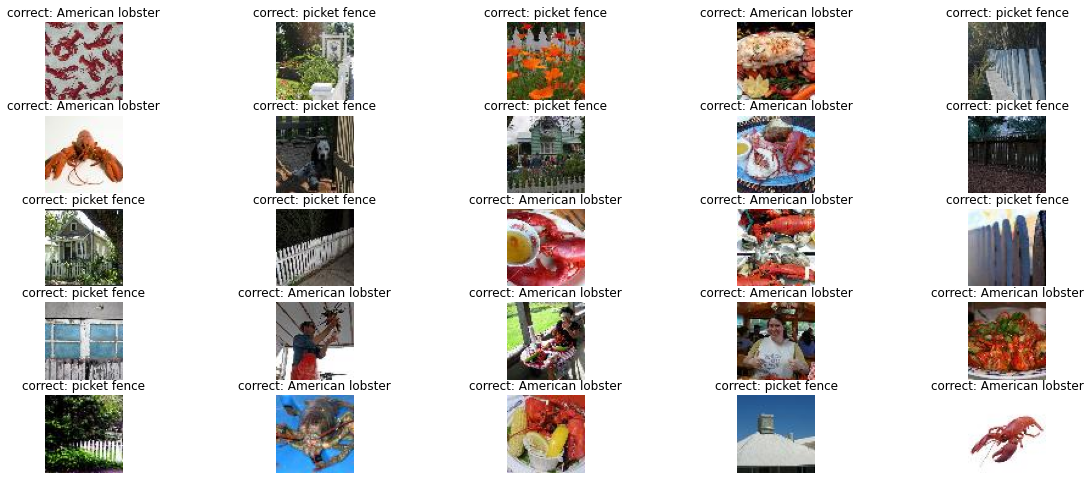

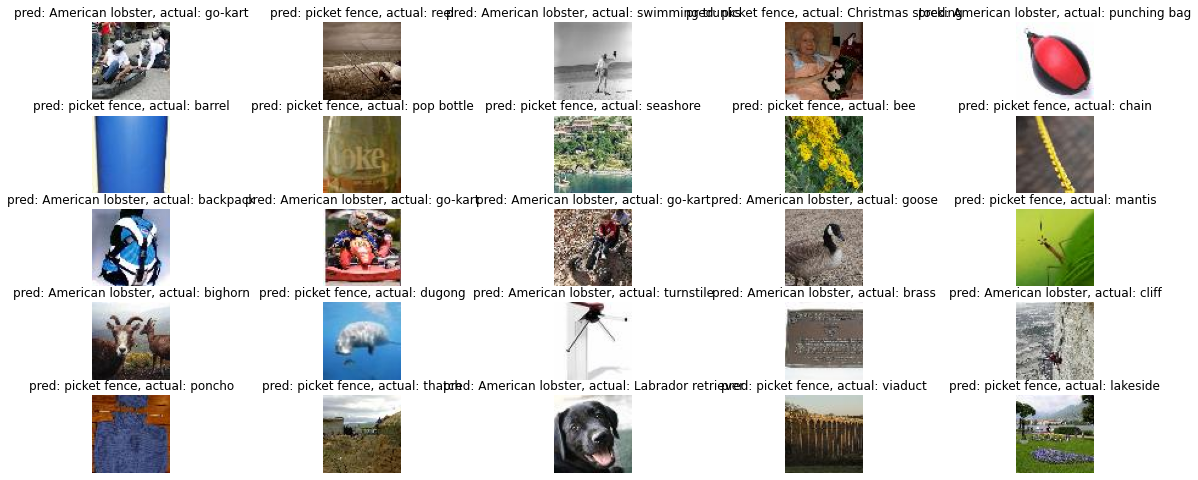

Sun Nov  1 02:08:10 2020 Train Epoch: 0 [0/100000 (0%)]	Loss: 5.308372
Sun Nov  1 02:08:18 2020 Train Epoch: 0 [25600/100000 (26%)]	Loss: 5.049142
Sun Nov  1 02:08:25 2020 Train Epoch: 0 [51200/100000 (51%)]	Loss: 4.599262
Sun Nov  1 02:08:32 2020 Train Epoch: 0 [76800/100000 (77%)]	Loss: 4.287928

Test set: Average loss: 4.2067, Accuracy: 854/8000 (11%)

Saved /gdrive/My Drive/colab_files/hw1/tiny_imagenet/logs/.14/000.pt

Sun Nov  1 02:08:43 2020 Train Epoch: 1 [0/100000 (0%)]	Loss: 4.155644
Sun Nov  1 02:08:50 2020 Train Epoch: 1 [25600/100000 (26%)]	Loss: 3.986166
Sun Nov  1 02:08:57 2020 Train Epoch: 1 [51200/100000 (51%)]	Loss: 3.771516
Sun Nov  1 02:09:04 2020 Train Epoch: 1 [76800/100000 (77%)]	Loss: 3.731348

Test set: Average loss: 3.7313, Accuracy: 1360/8000 (17%)

Saved /gdrive/My Drive/colab_files/hw1/tiny_imagenet/logs/.14/001.pt

Sun Nov  1 02:09:15 2020 Train Epoch: 2 [0/100000 (0%)]	Loss: 3.693331
Sun Nov  1 02:09:23 2020 Train Epoch: 2 [25600/100000 (26%)]	Loss: 3.711

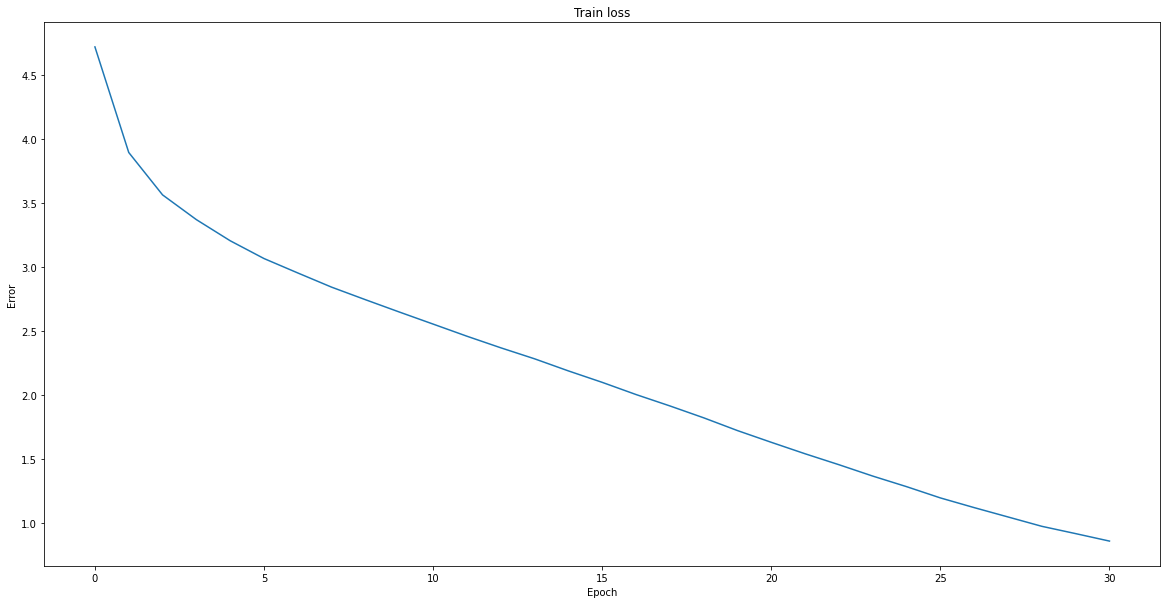

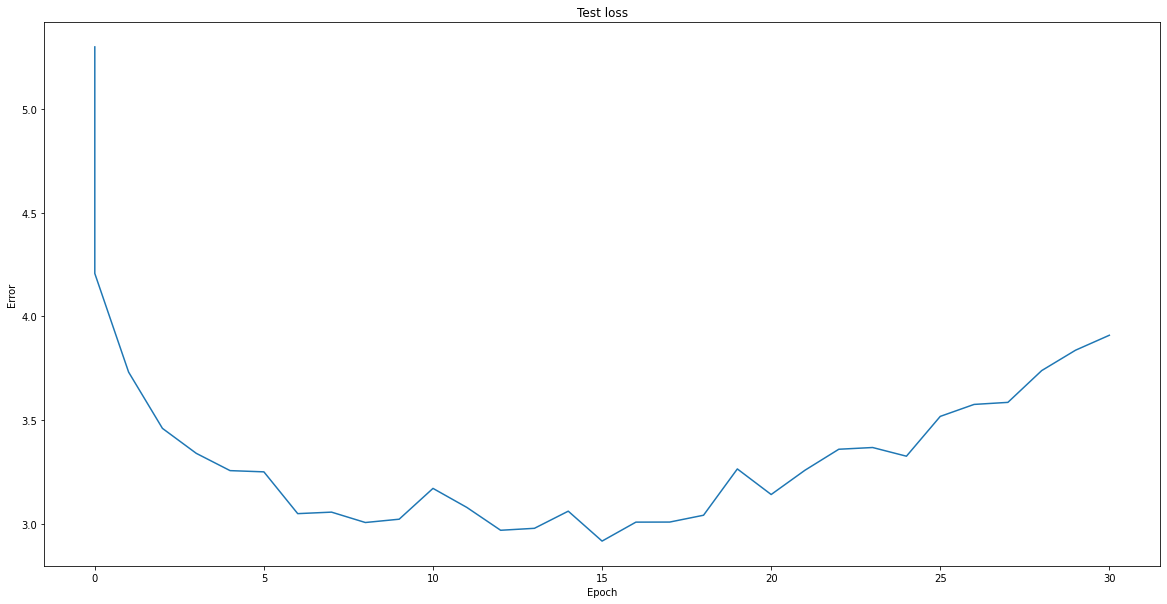

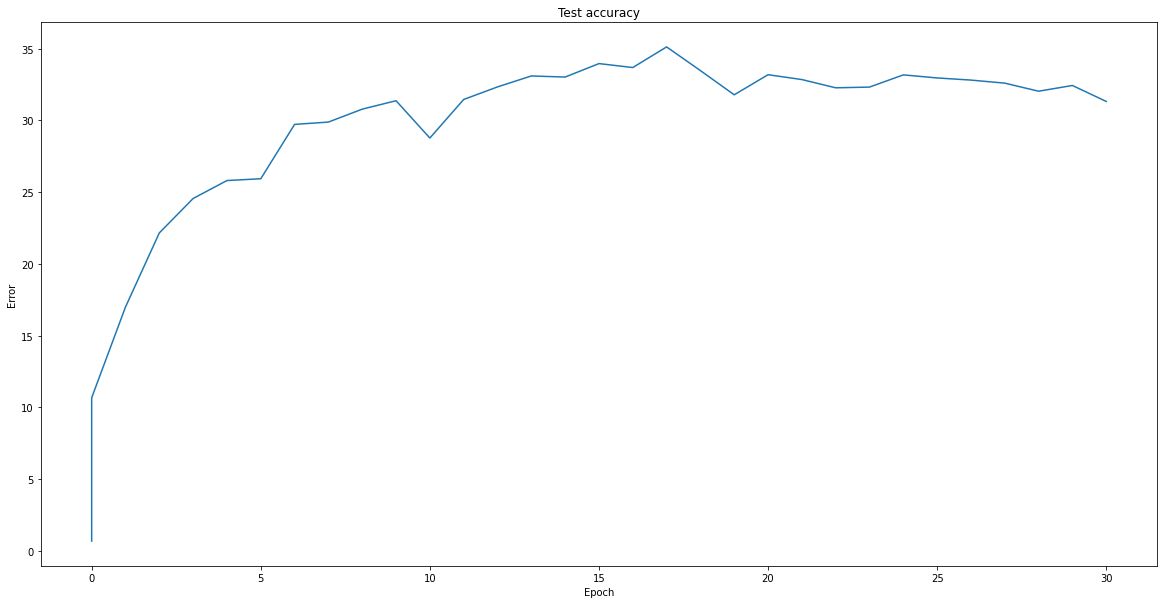

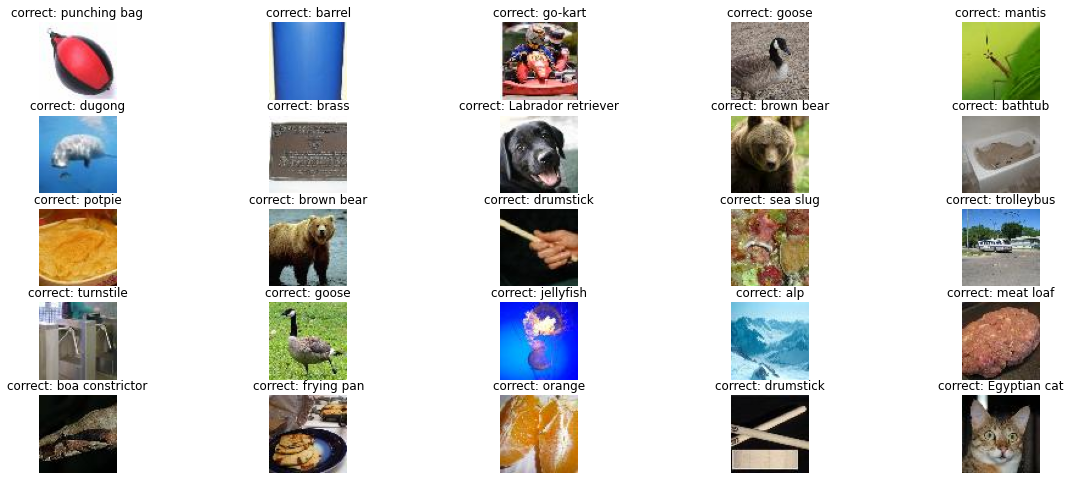

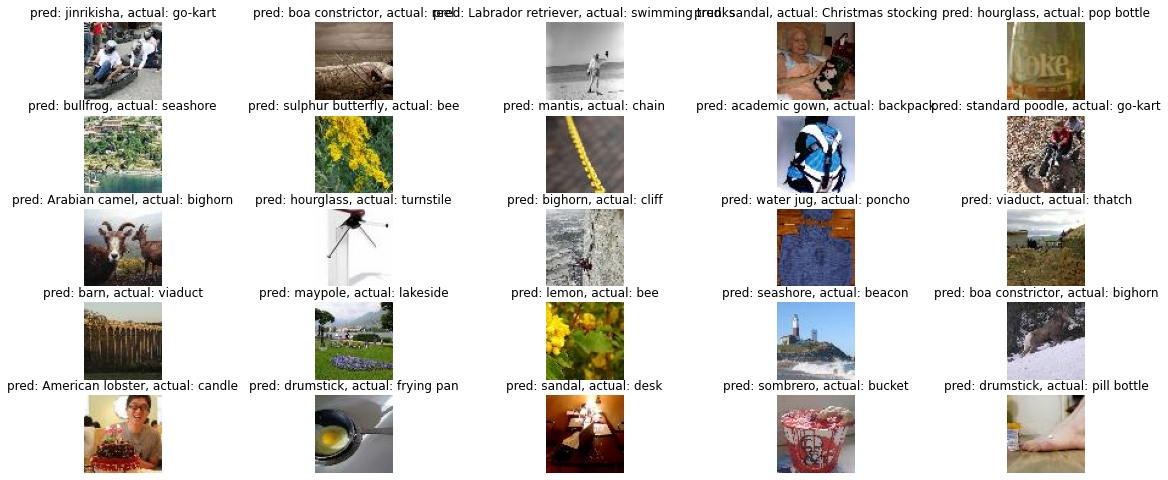

In [39]:
# Play around with these constants, you may find a better setting.
BATCH_SIZE = 256
TEST_BATCH_SIZE = 10
EPOCHS = 50
LEARNING_RATE = 0.01
MOMENTUM = 0.9
USE_CUDA = True
SEED = 0
PRINT_INTERVAL = 100
WEIGHT_DECAY = 0.0005

EXPERIMENT_VERSION = ".14" # increment this to start a new experiment
LOG_PATH = DATA_PATH + 'logs/' + EXPERIMENT_VERSION + '/'

# Now the actual training code
use_cuda = USE_CUDA and torch.cuda.is_available()

#torch.manual_seed(SEED)

device = torch.device("cuda" if use_cuda else "cpu")
print('Using device', device)
import multiprocessing
print('num cpus:', multiprocessing.cpu_count())

kwargs = {'num_workers': multiprocessing.cpu_count(),
          'pin_memory': True} if use_cuda else {}

class_names = [line.strip().split(', ') for line in open(DATA_PATH + 'class_names.txt')]
name_to_class = {line[1]: line[0] for line in class_names}
class_names = [line[1] for line in class_names]

train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                           shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                          shuffle=False, **kwargs)

model = TinyImagenetNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
start_epoch = model.load_last_model(LOG_PATH)

train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH + 'log.pkl', ([], [], []))
test_loss, test_accuracy, correct_images, correct_val, error_images, predicted_val, gt_val = test(model, device, test_loader, True)

correct_images = pt_util.to_scaled_uint8(correct_images.transpose(0, 2, 3, 1))
error_images = pt_util.to_scaled_uint8(error_images.transpose(0, 2, 3, 1))
pt_util.show_images(correct_images, ['correct: %s' % class_names[aa] for aa in correct_val])
pt_util.show_images(error_images, ['pred: %s, actual: %s' % (class_names[aa], class_names[bb]) for aa, bb in zip(predicted_val, gt_val)])

test_losses.append((start_epoch, test_loss))
test_accuracies.append((start_epoch, test_accuracy))

try:
    for epoch in range(start_epoch, EPOCHS + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch, PRINT_INTERVAL)
        test_loss, test_accuracy, correct_images, correct_val, error_images, predicted_val, gt_val = test(model, device, test_loader, True)
        train_losses.append((epoch, train_loss))
        test_losses.append((epoch, test_loss))
        test_accuracies.append((epoch, test_accuracy))
        pt_util.write_log(LOG_PATH + '.pkl', (train_losses, test_losses, test_accuracies))
        model.save_best_model(test_accuracy, LOG_PATH + '%03d.pt' % epoch)


except KeyboardInterrupt as ke:
    print('Interrupted')
except:
    import traceback
    traceback.print_exc()
finally:
    model.save_model(LOG_PATH + '%03d.pt' % epoch, 0)
    ep, val = zip(*train_losses)
    pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
    ep, val = zip(*test_losses)
    pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
    ep, val = zip(*test_accuracies)
    pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
    correct_images = pt_util.to_scaled_uint8(correct_images.transpose(0, 2, 3, 1))
    error_images = pt_util.to_scaled_uint8(error_images.transpose(0, 2, 3, 1))
    pt_util.show_images(correct_images, ['correct: %s' % class_names[aa] for aa in correct_val])
    pt_util.show_images(error_images, ['pred: %s, actual: %s' % (class_names[aa], class_names[bb]) for aa, bb in zip(predicted_val, gt_val)])


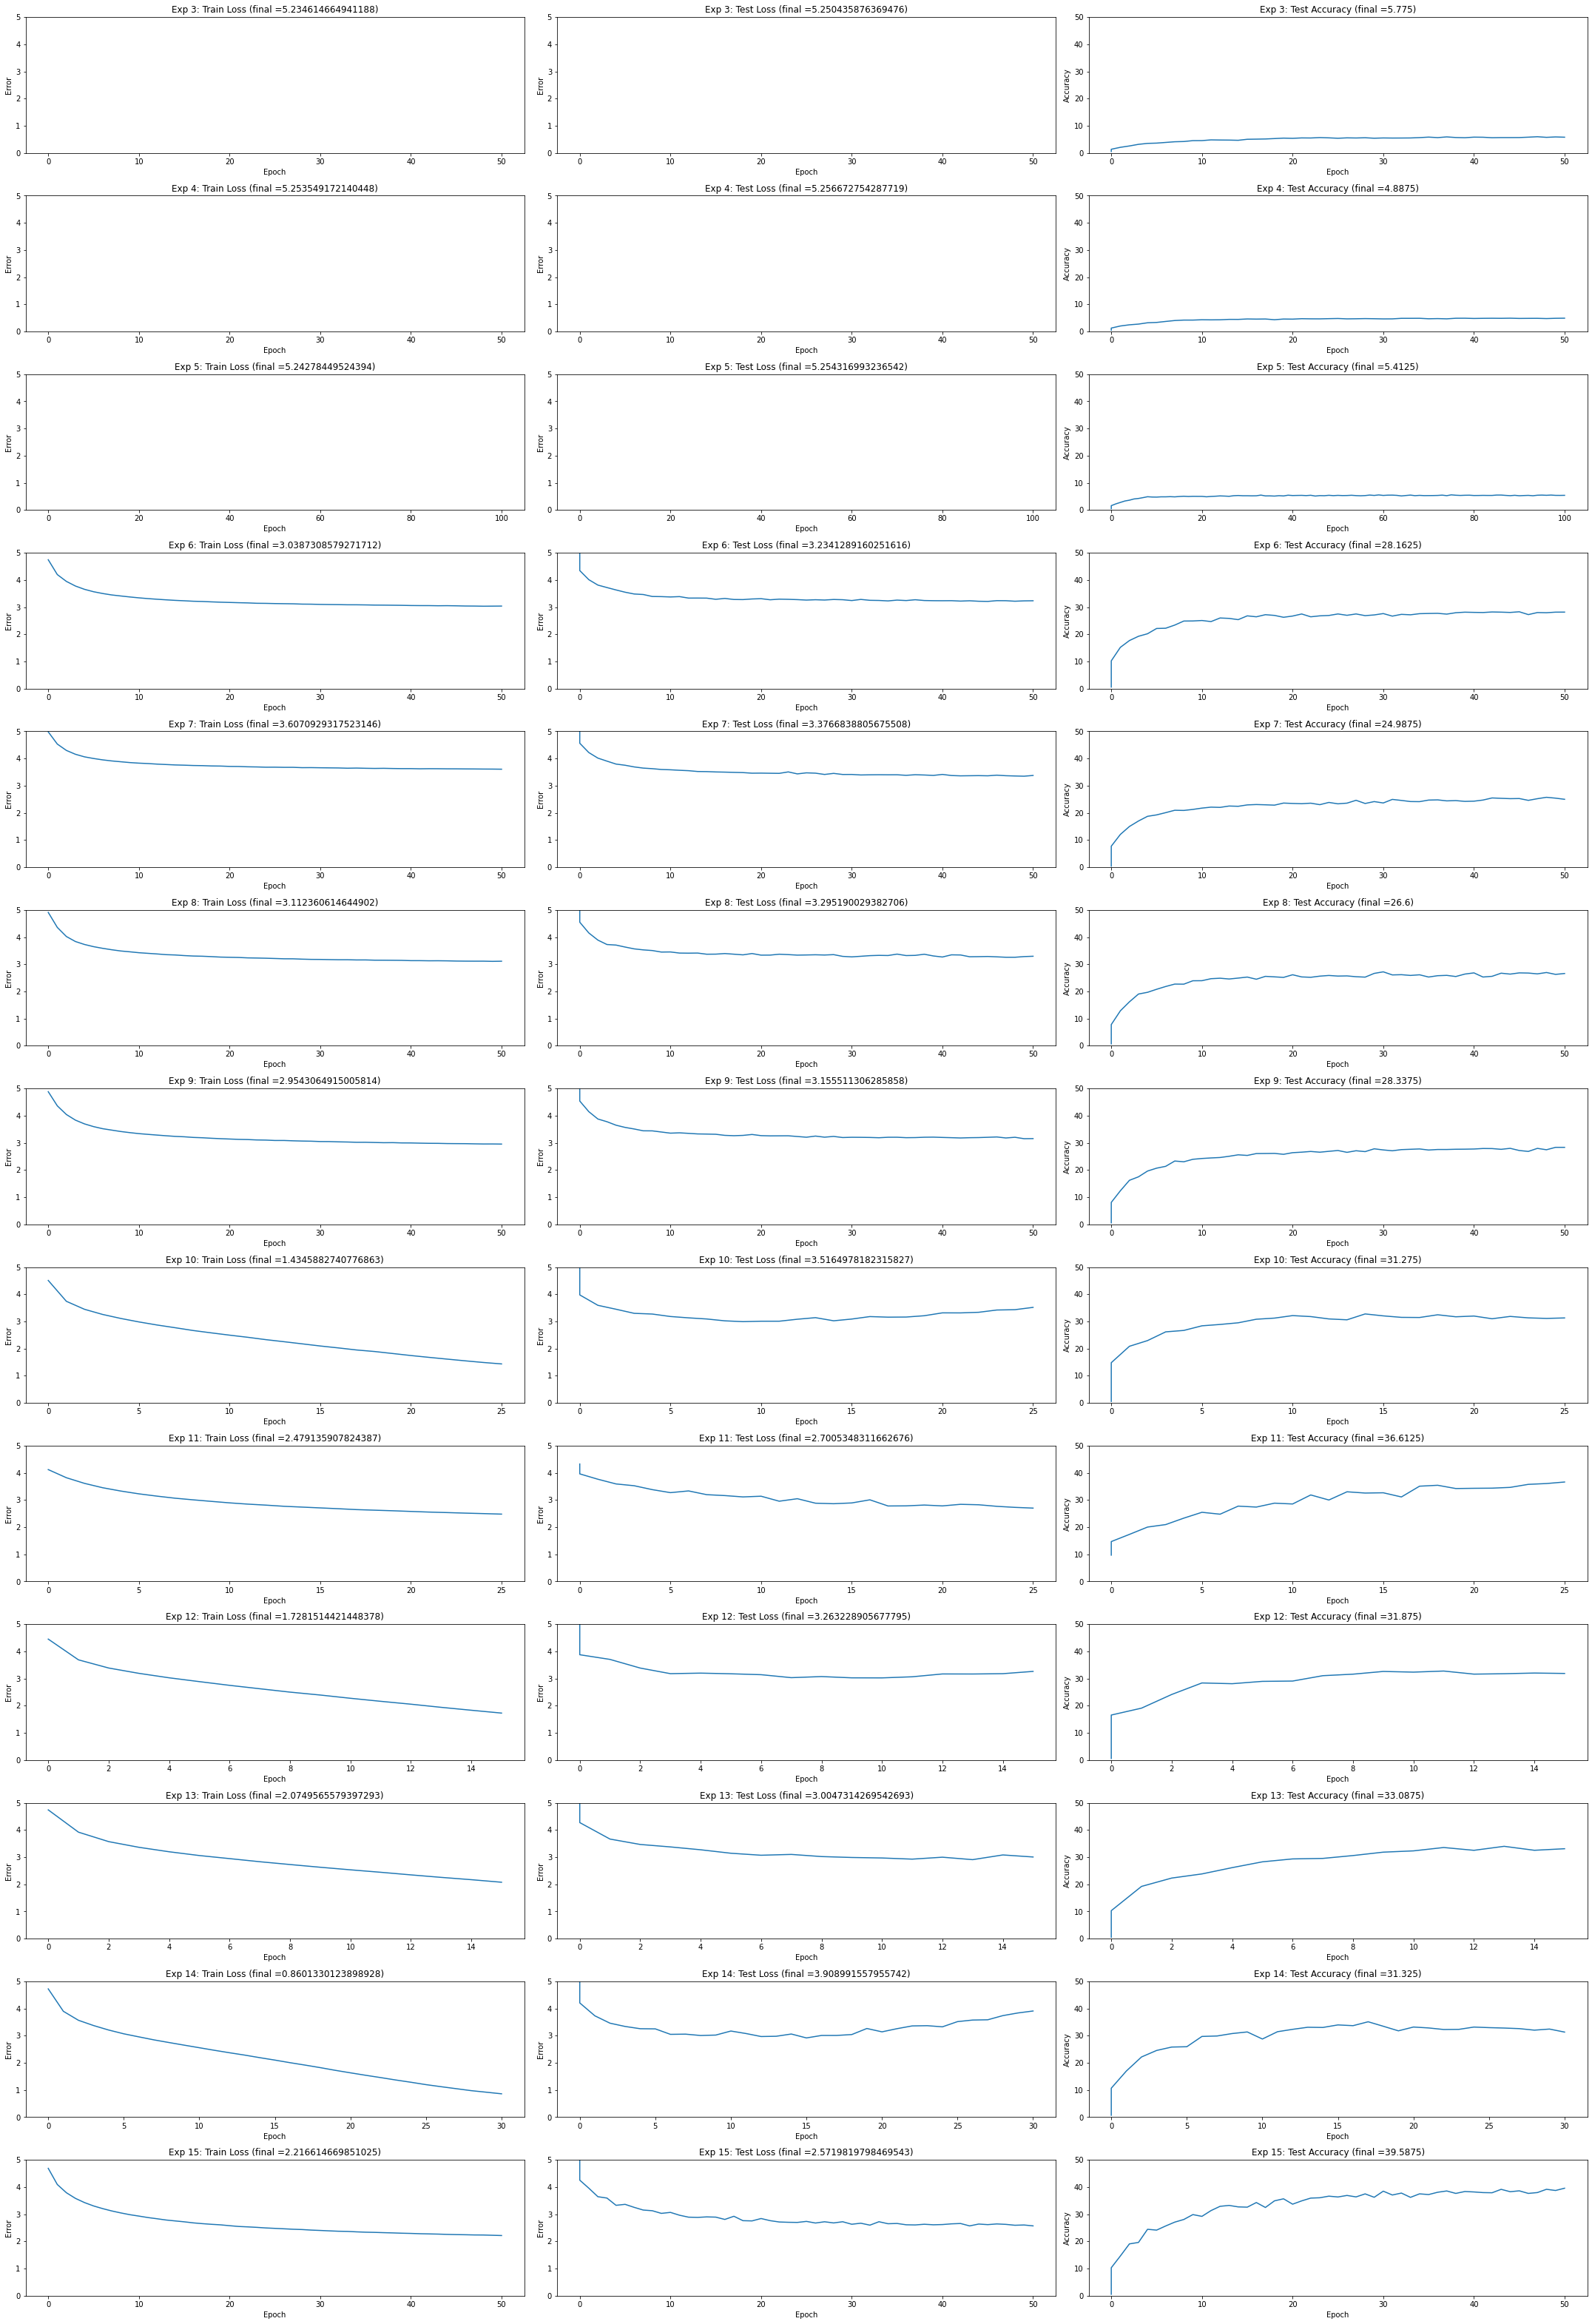

In [33]:
# exp 1 is mirroring reference darknet structure without batch normalization
# i.e. 6 layers with increasing channels and decreasing image size via maxpooling 
# and striding convolutions by 2
# 0.2 add normalization
# logs from these didn't save, they were both terrible accuracy: 
# Test set: Average loss: 5.2983, Accuracy: 42/8000 (1%)
# exp3: batch normalization after each layer, increased epochs to 50, plus softmax at end

# exp 4 data augmentation with random erase and dropout for the first couple layers
# exp 5 removing dropout and doing 100 epochs. Ugh, not working
# exp 6 trying out the same architecture we used for CIFAR
# exp 7 finally, some results. Adding dropout to right before fully connected layer. 
# exp 8 removing dropout, putting batchnorm directly after convolution this time (at 27% now)
# exp 9 simply adding a fourth layer
# exp 10: half the epochs, don't stride on convolutions, replace last layer (plus another one) with fully connected layers
# exp 11: properly following darknet 
# exp 12: From exp 10, doubling #connections between full layers to 1024, reducing epochs to 15 since we plateu'd quickly on exp 10
# exp 13: adding another layer between those
# exp 14: simply doubling epochs from 15 to 30
# exp 15: darknet with 50  epochs

plt.rcParams["figure.figsize"] = [30, 50]
num_exp = 15; 
for i in range(3, num_exp+1): 
  for j in range (3): 
    LOG_PATH_GRAPH = DATA_PATH + 'logs/' + "0." + str(i) + '/' + '.pkl'
    file_graph = pt_util.read_log(LOG_PATH_GRAPH) 
    # if not file_graph: 
    #   print("missing " + str(i))
    #   continue
    plt.subplot(num_exp, 3, 3 * (i - 2) + j - 2)
    plt.ylim(0, 50 if j == 2 else 5)
    plt.plot([x for x,y in file_graph[j]], [y for x,y in file_graph[j]])

    title_label = ['Train Loss', 'Test Loss', 'Test Accuracy']
    y_label = ['Error', 'Error', 'Accuracy']
    plt.title('Exp ' + str(i) + ': ' + str(title_label[j]) + ' (final =' + str(file_graph[j][-1][1]) + ')')
    plt.xlabel('Epoch')
    plt.ylabel(str(y_label[j]))

plt.tight_layout()
plt.show()

In [ ]:
# file_specific = pt_util.read_log(DATA_PATH + 'logs/' + "0.9" + '/' + '.pkl')
# print(file_specific[2])
for i in range(3, num_exp+1): 
  LOG_PATH_GRAPH = DATA_PATH + 'logs/' + "0." + str(i) + '/' + '.pkl'
  file_graph = pt_util.read_log(LOG_PATH_GRAPH) 
  print("Exp " + str(i) + " (acc: " + str(file_graph[2][-1][1]) + ")" )

Exp 3 (acc: 5.775)
Exp 4 (acc: 4.8875)
Exp 5 (acc: 5.4125)
Exp 6 (acc: 28.1625)
Exp 7 (acc: 24.9875)
Exp 8 (acc: 26.6)
Exp 9 (acc: 28.3375)


## TinyImageNet Questions

1. What design that you tried worked the best? How many epochs were you able to run it for? Provide the same information from CIFAR question 1.

The design that worked best was modeled off darknet; we were able to run it for 50 epochs, and it could run for longer. Here's our progress: 

 - Exp 1: Incorrectly mirroring the darknet structure with the following changes: 
  - no batch normalization
  - 6 layers with increasing channels and decreasing image size via maxpooling (all the way to 1x1). 
  - Our convolutions also strided by 2. 
 - Exp 2: Adding normalization.

Both of these were like 1% accuracy, and the logs didn't save.

 - Exp 3: Batch normalization after each maxpool, increased epochs to 50, plus softmax at end (acc: 5.775). 
 - Exp 4: Data augmentation with random erase and dropout for the first couple layers (acc: 4.8875).
 - Exp 5: Removing dropout and doing 100 epochs (acc: 5.4125).
 - Exp 6: Trying out the same architecture we used for CIFAR (acc: 28.1625).
 - Exp 7: Adding dropout to right before fully connected layer (acc: 24.9875).
 - Exp 8: Removing dropout, putting batchnorm directly after convolution this time (acc: 26.6).
 - Exp 9: Adding a fourth layer (acc: 28.3375).
 - Exp 10: half the epochs, don't stride on convolutions, replace last layer (plus another one) with fully connected layers (acc: 31.275).
 - Exp 12: Doubling connections between full layers to 1024, reducing epochs to 15 since we plateu'd quickly on exp 10 (acc: 31.875).
 - Exp 13: Adding another layer between those (acc: 33.0875).
 - Exp 14: Simply doubling epochs from 15 to 30 (acc: 31.325).
 - Exp 11: (done in parallel) Properly following darknet (acc: 36.6125). 
 - Exp 15: Darknet now with 50 epochs (acc: 39.5875).

2. Were you able to use larger/deeper networks on TinyImageNet than you used on CIFAR and increase accuracy? If so, why? If not, why not?

Yes. We tried using the same model as with CIFAR (on experiments 6-9, with slight modifications on further experiments), and we only netted an accuracy of 28.3375%. We then tried adding some more fully-connected layers at the end of the network, which netted us 33% accuracy. Running that network with many epochs would not have been very feasible/ efficient on CIFAR. We finally ran a network (properly, unlike our first few attempts) following the DarkNet Reference architecture, and got up to 39.5875% accuracy. It's much larger and deeper (twice as many layers) than the network we used for CIFAR, and ran well and resulted in a much better accuracy. 

3. The real ImageNet dataset has significantly larger images. How would you change your network design if the images were twice as large? How about smaller than Tiny ImageNet? How do you think your accuracy would change? This is open-ended, but we want a more thought-out answer than "I'd resize the images" or "I'd do a larger pooling stride." You don't have to write code to test your hypothesis.

If they were bigger: 

 - Follow the rough pattern of the DarkNet: Add a new convolutional layer before the average pool layer with double the number of filters as the previous convolutional layer, along with a batch normalization and maxpool layer.
 - Making the network more efficient with grouped convolutions that split up the feature map. 
 - Using residual connections (along with batch normalization, of course) to make sure gradient vanishing doesn't occur along this most likely larger network. 
 - Utilizing and building upon a pretrained network (not sure if this is a copout answer) for the upper layers (copy the weights of our current model). 
 - Substantially increase the number of epochs. Borrow some computational power through the cloud, and maybe try out some of the ResNet-style models from PyTorch

If they were smaller: 
 - Include more fully-connected layers at the end of my network, since pixels across the image may be more closely related
 - Remove striding, since every pixel matters
 - Run the network for more epochs to be utilize the network capabilities
 - Remove the 
  - Convolutional
  - Maxpool
  - Batch normalization
 - of layer 4. This would more closely mirror the DarkNet Reference architecture.

About accuracy: 

Humans are able to recognize clear/ high-resolution images more easily than blurry/ low-resolution ones. Along those lines, although designing a network is harder, a properly-engineered network, which trains for long enough, may be able to achieve much higher accuracy with larger images than smaller ones. With more data, there's more information in the image to distinguish from, and the network has more features available to learn (it may reduce the resolution entirely to proceed with the same scenario as the smaller images, or proceed with some better strategy). 

# Turn-in

Download your `hw1.ipynb` and put it in your `uwnet` repository.